In [222]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sac_model import weights_init_
from torch.distributions import Normal
import matplotlib.pyplot as plt

In [223]:
class ThalamoCortical(nn.Module):
    def __init__(self, inp_dim, hid):
        super(ThalamoCortical, self).__init__()
        self.inp_dim = inp_dim
        self.hid = hid

        # Unload fixed weights
        weights = torch.load("checkpoints/thalamocortical_init.pth")

        # Cortical Weights
        self.J_cc = weights["Jcc"]
        self.lick_J_ct = weights["lick_Jct"]

        # Thalamic Weights
        self.lick_J_tc = weights["lick_Jtc"]

        # Thalamic Timescale (not sure what to put)
        self.tau = 1.

        # Readout for probability
        self.W_out = weights["W_out"]

        self.cortical_activity = torch.zeros(size=(hid,))
        self.c_init_mu = torch.zeros(size=(hid,))

    # TODO learn the preparatory weights and add that into the network so that each switch starts with correct initial condition
    def forward(self, x):

        # discrete dynamics with forward euler (dt = 1)
        self.thalamic_activity = self.lick_J_tc @ self.cortical_activity + x
        # make this relu just 0 or 1 instead
        self.cortical_activity = self.J_cc @ self.cortical_activity + self.lick_J_ct @ self.thalamic_activity
        lick_prob = self.W_out @ self.cortical_activity

        return lick_prob

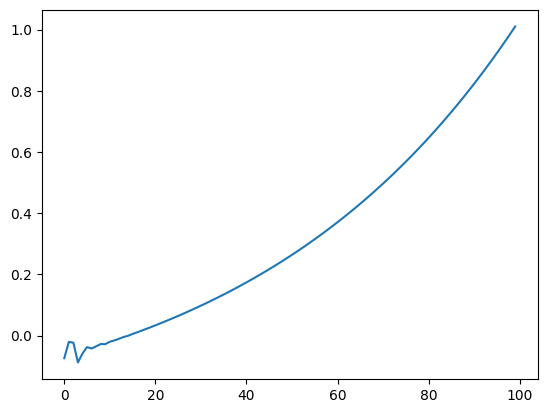

In [224]:
net = ThalamoCortical(1, 64)
test_input_lick = torch.ones(size=(int(1/.01),))*1

cortical_series = []
for t in range(test_input_lick.shape[0]):
    cortical_out = net(test_input_lick[t])
    cortical_series.append(cortical_out.item())

plt.plot(cortical_series)
plt.show()